In [1]:
import os.path as path
import raw_data_preprocessing as rdp
import warnings
import regressor as reg
import cluster as clu
import intervention_data_preprocessing as idp
import individual_differences_plot as plot
warnings.filterwarnings('ignore')

googledrive_loc = '/datasets/yis-google-drive'
data_folder_loc = 'Yi_UCI_research/GSR other works/2020 Summer_predict individual training/data/'
file_name = 'raw data/combined_3datasets.csv'
data_path = path.join(googledrive_loc, data_folder_loc, file_name)
raw_data = rdp.read_raw_data(data_path)
print('Used Feature columns: {}'.format(rdp.feature_col_names))
data_nomissing_training = rdp.delete_missing_row(raw_data)
# rdp.demographic_info(data_nomissing_training)
descpriptive_result = rdp.descriptive_info(data_nomissing_training)

Used Feature columns: ['MR_accpre', 'WM_Zpre', 'IC_Zreverse_pre', 'NT_Zpre', 'TCA_Zscore', 'CFQMALscore', 'Avg_grit_amb', 'NEOFFIExtraversion', 'NEOFFIAgreeableness', 'NEOFFIConscientiousness', 'NEOFFIEmotionalstability', 'NEOFFIIntellectorOpenness', 'VGQHoursCategorySumPastYear_Z', 'ParentalEducationSum', 'SelfReportedSESRatingSum', 'Physicalhealth', 'Physicalfitness', 'Psychohealth', 'Gamified', 'Difficulty', 'Bilingual']
The sample size of raw data is 949.
The sample size of no missing data (listwise) is 568.
Categorical Gamified information:Gamified
Gamified       315
Nongamified    253
dtype: int64
Categorical Difficulty information:Difficulty
Difficult     50
Middle       181
Moderate     169
hard         150
dtype: int64
Categorical Bilingual information:Bilingual
Bilingual      403
Monolingual    103
dtype: int64


In [2]:
# clean intervention data (delete outliers)
int_test = idp.InterventionProcessor(data_nomissing_training)
int_test.basic_analyze()
int_test.mark_outlier_stewd(['std','mean'])
int_test.delete_outlier()

The average maximun span across sessions is 5.157 with sd 5.815
The average standard deviation across sessions is 0.874 with sd 1.782
The average span across sessions is 3.920 with sd 3.733
The skew of std is 7.766
std:MC=0.193
interval of std is 2.6941854040225532 to -0.15348068866153236
     Unique  mean_1  mean_2  mean_3  mean_4  mean_5  mean_6  mean_7  mean_8  \
33       34   4.140   6.510   9.100   7.920   9.050   9.130   8.830  13.560   
41       42   4.150   7.010  18.550  29.390  38.250  43.580  49.000  51.500   
44       45   2.530   2.420   2.770   3.070   2.550   2.780   2.740   3.550   
147     148   2.510   3.010   3.520   3.960   5.700   7.230   8.600  10.450   
472     473   3.000   3.000   4.000   4.000   6.000   7.000   9.000  10.000   
505     506   4.000   7.000   9.000   8.000   9.000   9.000   9.000  14.000   
582     583   3.000   2.000   3.000   3.000   3.000   3.000   3.000   4.000   
583     584   4.000   7.000  19.000  29.000  38.000  44.000  49.000  52.000   

In [3]:
#using regressor to fit individual training data
piece_lin_reg = reg.PiecewiselinRegressor(['knot', 'slope1', 'slope2','turning_value'])
log_lin_reg = reg.LogRegressor(['log_slope', 'log_bias'])
lin_reg = reg.LinearRegressor(['linear_slope', 'linear_bias'])

# ['knot','slope1','slope2','std','max','r2','turning_value']
# ['linear_slope', 'linear_bias']
int_test.register_regressor(piece_lin_reg)
int_test.fit()
# plot.plot_distribution(int_test.data, ['knot','slope1','slope2','std','max','r2'])

The average r2 for <class 'regressor.PiecewiselinRegressor'> is: 0.728
The num of objects can not fit by pwlf: Unique            0
mean_1            0
mean_2            0
mean_3            0
mean_4            0
mean_5            0
mean_6            0
mean_7            0
mean_8            0
mean_9            0
mean_10           0
max               0
std               0
mean              0
outlier           0
knot             42
slope1           42
slope2           42
turning_value    42
r2               42
dtype: int64
The sample size that can fit with pwlf: 506


The silhouette score of AgglomerativeClustering(n_clusters=4) is: 0.402
The Davies-Bouldin score of AgglomerativeClustering(n_clusters=4) is: 0.622
Sample of each cluster: hierar_4
0    261
1    164
2     78
3      3
dtype: int64
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


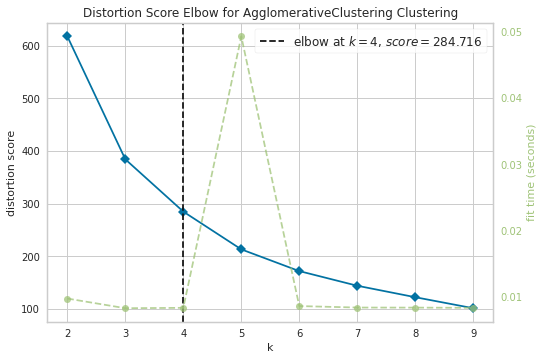

In [4]:
# clustering features
std_max = ['max','std'] 
pwlf = ['knot','slope1'] # 'turning_value'
all_sess = ['mean_' + str(i) for i in range(1,11)]


# clustering methods
kmeans_3com = clu.Kmeans(3, pwlf)
hac_3com = clu.hierarchical(4, pwlf)
em_3com = clu.EM(3, pwlf)
dbc = clu.density_based(3, pwlf)
# register clustering method
int_test.register_cluster_model(hac_3com)
int_test.cluster()
# plot
# plot.plot_cluster_result(int_test.data, int_test.intervention_col_names, int_test.clustering_model.cluster_name)
# plot.bar_plot_cluster(int_test.data, ['knot','slope1'], int_test.clustering_model.cluster_name)
# plot.plot_scatter_cluster(int_test.data, ['knot','slope1'], int_test.clustering_model.cluster_name)

In [10]:
# Feature preprocessing
import feature_preprocessor as fp
fp_test = fp.FeatureProcessor(data_nomissing_training,add_demographic=True)
fp_test.delete_missing_rows()
fp_test.make_dummy()
fp_test.features_impute_missing()


#fp_test.corr_features()
#fp_test.distri_features()
#fp_test.discretize_features()

Original length of data is : 568
Delete rows have >= 6 missing values in features
The data length now is :524
Feature MR_accpre missing counts: 1(0.2 %)
Feature WM_Zpre missing counts: 2(0.4 %)
Feature IC_Zreverse_pre missing counts: 1(0.2 %)
Feature NT_Zpre missing counts: 1(0.2 %)
Feature TCA_Zscore missing counts: 0(0.0 %)
Feature CFQMALscore missing counts: 0(0.0 %)
Feature Avg_grit_amb missing counts: 0(0.0 %)
Feature NEOFFIExtraversion missing counts: 0(0.0 %)
Feature NEOFFIAgreeableness missing counts: 0(0.0 %)
Feature NEOFFIConscientiousness missing counts: 0(0.0 %)
Feature NEOFFIEmotionalstability missing counts: 0(0.0 %)
Feature NEOFFIIntellectorOpenness missing counts: 0(0.0 %)
Feature VGQHoursCategorySumPastYear_Z missing counts: 2(0.4 %)
Feature ParentalEducationSum missing counts: 24(4.6 %)
Feature SelfReportedSESRatingSum missing counts: 0(0.0 %)
Feature Physicalhealth missing counts: 42(8.0 %)
Feature Physicalfitness missing counts: 42(8.0 %)
Feature Psychohealth missin

In [ ]:
# add label column for dummy
def label_change_hie (row):
   if row['hierar_3'] == 0:
      return 1
   return 0
def label_change_hie2 (row):
   if row['hierar_3'] == 1:
      return 1
   if row['hierar_3'] == 2:
      return 0
   return None

In [ ]:
int_test.data['whether_talent'] = int_test.data.apply (lambda row: label_change_hie(row), axis=1)
int_test.data['whether_longer'] = int_test.data.apply (lambda row: label_change_hie2(row), axis=1)

In [ ]:
import classification_preprocessor as cp
cp_test = cp.ClassifyPreprocessor(int_test.data, fp_test.data, 'whether_talent')
cp_test.delete_missing()
cp_test.features_impute_missing()
# cp_test.delete_outlier() 
# cp_test.feature_test()
# cp_test.feature_selection(10)
# cp_test.use_categorical_features()

Count total NaN at each column in a DataFrame : MR_accpre                         1
WM_Zpre                           1
IC_Zreverse_pre                   0
NT_Zpre                           2
TCA_Zscore                       36
CFQMALscore                      38
Avg_grit_amb                     37
NEOFFIExtraversion               38
NEOFFIAgreeableness              38
NEOFFIConscientiousness          38
NEOFFIEmotionalstability         38
NEOFFIIntellectorOpenness        38
VGQHoursCategorySumPastYear_Z    38
ParentalEducationSum             57
SelfReportedSESRatingSum         35
Physicalhealth                   74
Physicalfitness                  74
Psychohealth                     74
Gamified                          0
Difficulty                        6
Bilingual                        59
dtype: int64
Data length now is :467
Count total NaN at each column in a DataFrame after delete : MR_accpre                         1
WM_Zpre                           1
IC_Zreverse_pre           

In [ ]:
#cp_test.data.to_csv(path.join(googledrive_loc, data_folder_loc, 'predictors_label_2022.csv'))

In [ ]:
X, Y, orig_len, feature_names = cp_test.resample_standardize({0:81, 1:164}, oversample=False)
print('The input and output shape: {} and {}'.format(X.shape, Y.shape))
saved_data_path = path.join(googledrive_loc, data_folder_loc, 'saved data/2022/binary_classify_talent/')
# cp_test.save_data(X, Y, orig_len, feature_names, saved_data_path)

The sample weight before resample: Counter({0: 393, 1: 74})
The input and output shape: (467, 26) and (467,)


In [ ]:
# split a seperate testset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
cp_test.save_data(X_train, X_test, y_train, y_test, orig_len, feature_names, saved_data_path)

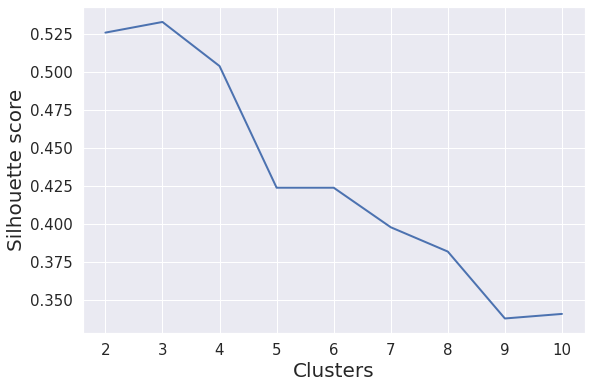

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.526, 0.533, 0.504, 0.424, 0.424, 0.398, 0.382, 0.338, 0.341]


fig, ax = plt.subplots(figsize=(9,6))
ax.tick_params(labelsize=15)
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Clusters', fontsize=20)
ax.set_ylabel('Silhouette score', fontsize=20)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c9e1ba2-0cb9-40ed-a01b-b56de82eb464' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>